In [1]:
import os
import h5py
import shutil
import pandas as pd
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.visualization import make_lupton_rgb
from collections import Counter
from tensorflow import keras
from astropy.wcs import WCS,utils

from functions import train_autoencoder

# Initialize hdf5 file

In [2]:
os.path.expandvars("$SLURM_TMPDIR")

'/localscratch/anahoban.5043391.0'

In [3]:
hf = h5py.File(os.path.expandvars("$SCRATCH")+"/labelled_cutouts_64p.h5", "w")
hf.close()

In [4]:
src = os.path.expandvars("$SCRATCH") + "/labelled_cutouts_64p.h5"
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"
shutil.copy2(src, dest)

'/localscratch/anahoban.5043391.0/labelled_cutouts_64p.h5'

In [5]:
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"
hf = h5py.File(dest + "labelled_cutouts_64p.h5", "r+")

In [6]:
#hf.close()

### Looking at the candidates

In [6]:
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"
label_dir = "labels/"

In [7]:
tile_file = open(image_dir + "tiles_cand.list", "r")
tile_list = tile_file.readlines()
for i in range(len(tile_list)):
    tile_list[i] = tile_list[i][:-1] # Remove new line characters
    print(tile_list[i])
tile_file.close()

CFIS.000.184.u
CFIS.000.187.u
CFIS.000.223.u
CFIS.000.226.u
CFIS.001.234.u
CFIS.002.208.u
CFIS.003.190.u
CFIS.003.212.u
CFIS.004.180.u
CFIS.004.183.u
CFIS.004.217.u
CFIS.005.216.u
CFIS.005.217.u
CFIS.006.182.u
CFIS.007.184.u
CFIS.007.203.u
CFIS.007.229.u
CFIS.008.244.r
CFIS.008.244.u
CFIS.009.202.u
CFIS.009.213.u
CFIS.010.210.u
CFIS.011.180.u
CFIS.011.184.u
CFIS.012.180.u
CFIS.012.183.u
CFIS.012.187.u
CFIS.012.228.u
CFIS.013.187.u
CFIS.013.189.u
CFIS.013.191.u
CFIS.013.200.u
CFIS.013.210.u
CFIS.013.214.u
CFIS.013.231.u
CFIS.013.259.u
CFIS.014.193.u
CFIS.015.204.u
CFIS.016.179.u
CFIS.016.182.u
CFIS.016.195.u
CFIS.016.203.u
CFIS.017.185.u
CFIS.017.189.u
CFIS.018.182.u
CFIS.018.198.u
CFIS.019.195.u
CFIS.019.219.u
CFIS.019.237.u
CFIS.020.181.u
CFIS.021.179.u
CFIS.021.203.u
CFIS.022.182.u
CFIS.022.191.u
CFIS.022.200.u
CFIS.025.190.u
CFIS.025.202.u
CFIS.027.188.u
CFIS.027.197.u
CFIS.027.223.u
CFIS.028.179.u
CFIS.028.180.u
CFIS.028.186.u
CFIS.028.228.u
CFIS.028.234.u
CFIS.029.179.u
CFIS.029.1

In [8]:
len(tile_list)

1636

In [10]:
label_subdirs = ["stronglensdb_confirmed_unige/", "stronglensdb_candidates_unige/", "canameras2020/",
                 "huang2020a_grade_A/", "huang2020a_grade_B/", "huang2020a_grade_C/", 
                 "huang2020b_grade_A/", "huang2020b_grade_B/", "huang2020b_grade_C/"]
filters = ["CFIS u/", "PS1 g/", "CFIS r/", "PS1 i/", "PS1 z/"]
filter_dict = {k:v for v,k in enumerate(filters)}

In [11]:
cd '/scratch/anahoban/stronglens/Code/Batch Loading/Currently used'

/scratch/anahoban/stronglens/Code/Batch Loading/Currently used


In [12]:
ls

 AnaTests.ipynb                     func_job2.py
'Create Filtered Cutouts.ipynb'     functions.py
'Lens Binary Classifier.ipynb'      job3.py
'Multi-Channel Autoencoder.ipynb'   job8-unbalanced_tiles-5039881.out
 New_fcts.ipynb                     job_outputs/
'Plot Labelled Cutouts.ipynb'       job_scripts/
 Twobands_tests.ipynb               labels/
 __pycache__/                       norm_tests.ipynb
 analysis_cutouts.ipynb             script_cat.sh
 create_cutouts.py                  script_job3.sh
 create_mastercat.py                slurm-5046791.out
 create_models.py                   wandb/
 func_job1.py


In [13]:
for label_subdir in label_subdirs:
    for f in filters:
        nlabels = 0
        subdir = './' + label_dir + label_subdir + f
        for t in os.listdir(subdir):
            if t == ".ipynb_checkpoints":
                nlabels += 0
            else:
                df = pd.read_csv(subdir + t)
                nlabels += len(df)
        print("Number of labels in {}: {}".format(subdir, nlabels))

Number of labels in ./labels/stronglensdb_confirmed_unige/CFIS u/: 199
Number of labels in ./labels/stronglensdb_confirmed_unige/PS1 g/: 29
Number of labels in ./labels/stronglensdb_confirmed_unige/CFIS r/: 182
Number of labels in ./labels/stronglensdb_confirmed_unige/PS1 i/: 28
Number of labels in ./labels/stronglensdb_confirmed_unige/PS1 z/: 23
Number of labels in ./labels/stronglensdb_candidates_unige/CFIS u/: 416
Number of labels in ./labels/stronglensdb_candidates_unige/PS1 g/: 9
Number of labels in ./labels/stronglensdb_candidates_unige/CFIS r/: 148
Number of labels in ./labels/stronglensdb_candidates_unige/PS1 i/: 9
Number of labels in ./labels/stronglensdb_candidates_unige/PS1 z/: 9
Number of labels in ./labels/canameras2020/CFIS u/: 129
Number of labels in ./labels/canameras2020/PS1 g/: 1
Number of labels in ./labels/canameras2020/CFIS r/: 49
Number of labels in ./labels/canameras2020/PS1 i/: 1
Number of labels in ./labels/canameras2020/PS1 z/: 1
Number of labels in ./labels/h

In [14]:
!ls labels/stronglensdb_confirmed_unige/CFIS\ u

004.180_labels.csv  210.230_labels.csv	326.219_labels.csv  382.241_labels.csv
009.213_labels.csv  211.252_labels.csv	326.253_labels.csv  386.247_labels.csv
013.214_labels.csv  214.269_labels.csv	327.218_labels.csv  386.248_labels.csv
013.231_labels.csv  216.250_labels.csv	327.231_labels.csv  392.250_labels.csv
014.193_labels.csv  217.257_labels.csv	328.225_labels.csv  393.245_labels.csv
018.198_labels.csv  219.264_labels.csv	328.262_labels.csv  395.228_labels.csv
022.182_labels.csv  222.232_labels.csv	329.253_labels.csv  398.226_labels.csv
033.183_labels.csv  222.247_labels.csv	330.260_labels.csv  403.238_labels.csv
033.184_labels.csv  223.231_labels.csv	333.268_labels.csv  403.257_labels.csv
033.219_labels.csv  224.234_labels.csv	335.252_labels.csv  406.250_labels.csv
034.210_labels.csv  226.273_labels.csv	336.239_labels.csv  407.242_labels.csv
036.186_labels.csv  228.262_labels.csv	337.219_labels.csv  417.236_labels.csv
042.188_labels.csv  229.220_labels.csv	337.271_labels.csv  424.2

In [15]:
!ls labels/stronglensdb_confirmed_unige/CFIS\ r

051.245_labels.csv  206.264_labels.csv	244.284_labels.csv  277.286_labels.csv
068.321_labels.csv  211.252_labels.csv	244.294_labels.csv  292.256_labels.csv
070.320_labels.csv  212.301_labels.csv	244.296_labels.csv  294.238_labels.csv
147.282_labels.csv  213.274_labels.csv	245.284_labels.csv  296.253_labels.csv
147.288_labels.csv  214.269_labels.csv	245.289_labels.csv  297.255_labels.csv
154.285_labels.csv  216.250_labels.csv	245.290_labels.csv  299.246_labels.csv
154.286_labels.csv  217.257_labels.csv	245.297_labels.csv  300.251_labels.csv
156.285_labels.csv  219.264_labels.csv	246.289_labels.csv  319.290_labels.csv
159.283_labels.csv  222.247_labels.csv	246.291_labels.csv  328.262_labels.csv
162.275_labels.csv  226.273_labels.csv	247.291_labels.csv  330.260_labels.csv
163.275_labels.csv  227.295_labels.csv	248.272_labels.csv  333.268_labels.csv
164.278_labels.csv  228.262_labels.csv	249.287_labels.csv  336.239_labels.csv
164.282_labels.csv  229.294_labels.csv	253.263_labels.csv  337.2

In [35]:
ls

 AnaTests.ipynb                  'Multi-Channel Autoencoder.ipynb'   lenses/
'Create Filtered Cutouts.ipynb'  'Plot Labelled Cutouts.ipynb'
'Lens Binary Classifier.ipynb'    labels/


# Save labelled cutouts to hdf5 file

In [22]:
filters[0]+filters[2]

'CFIS u/CFIS r/'

In [15]:
cutout_size = 64
for label_subdir in label_subdirs[0]:
    for f in filters:
        subdir = label_dir + label_subdir + f
        for csv in os.listdir(subdir):
            if csv != ".ipynb_checkpoints":
                tile_id = csv[:7] # XXX.XXX id
                img_group_name = label_subdir + tile_id + "/" + f + "IMAGES"
                wt_group_name = label_subdir + tile_id + "/" + f + "WEIGHTS"
        
                if img_group_name not in hf:
                    img_group = hf.create_group(img_group_name)
                    wt_group = hf.create_group(wt_group_name)
                else:
                    img_group = hf[img_group_name]
                    wt_group = hf[wt_group_name]
                tile_name = f.split(" ")[0] + "." + tile_id + "." + f.split(" ")[1][0]
                if "CFIS" in f:
                    wt_name = ".weight.fits.fz"
                    wt_index = 1
                else:
                    wt_name = ".wt.fits"
                    wt_index = 0
            
                #shutil.copy2(image_dir + tile_name + ".fits", dest)
                #shutil.copy2(image_dir + tile_name + wt_name, dest)
                img_fits = fits.open(image_dir + tile_name + ".fits", memmap=True)
                wt_fits = fits.open(image_dir + tile_name + wt_name, memmap=True)
            
                df = pd.read_csv(subdir + csv)
                nlabels = len(df)
                for n in range(nlabels):
                    x = df["x"][n]
                    y = df["y"][n]
                    img_cutout = Cutout2D(img_fits[0].data, (x, y), cutout_size, mode="partial", fill_value=0).data
                    wt_cutout = Cutout2D(wt_fits[wt_index].data, (x, y), cutout_size, mode="partial", fill_value=0).data
                
                    img_lower = np.percentile(img_cutout, 1)
                    img_upper = np.percentile(img_cutout, 99)
                    if img_lower == img_upper:
                        img_norm = np.zeros((cutout_size, cutout_size))
                    else:
                        img_norm = (img_cutout - np.min(img_cutout)) / (img_upper - img_lower)

                    if (tile_id + str(n)) not in img_group:
                        img_group.create_dataset(tile_id + str(n), data=img_norm)
                        wt_group.create_dataset(tile_id + str(n), data=wt_cutout)

                img_fits.close()
                wt_fits.close()
    print(f"Finished {label_subdir}")

Finished canameras2020/
Finished huang2020a_grade_A/
Finished huang2020a_grade_B/
Finished huang2020a_grade_C/
Finished huang2020b_grade_A/
Finished huang2020b_grade_B/
Finished huang2020b_grade_C/


In [16]:
hf.close()
src = os.path.expandvars("$SLURM_TMPDIR") + "/labelled_cutouts_64p.h5"
dest = os.path.expandvars("$SCRATCH") + "/"
shutil.copy2(src, dest)

'/scratch/anahoban/labelled_cutouts_64p.h5'

# Look at confirmed cutouts from random CFIS tile

In [126]:
subdir = label_dir + label_subdirs[0]
u_tiles = os.listdir(subdir + filters[0])
print(u_tiles)

['197.271_labels.csv', '248.272_labels.csv', '203.263_labels.csv', '165.270_labels.csv', '314.228_labels.csv', '640.188_labels.csv', '050.212_labels.csv', '206.264_labels.csv', '228.262_labels.csv', '324.225_labels.csv', '009.213_labels.csv', '358.225_labels.csv', '248.235_labels.csv', '661.184_labels.csv', '340.274_labels.csv', '346.224_labels.csv', '222.232_labels.csv', '361.249_labels.csv', '367.182_labels.csv', '403.238_labels.csv', '683.198_labels.csv', '164.282_labels.csv', '264.299_labels.csv', '290.235_labels.csv', '690.181_labels.csv', '356.257_labels.csv', '442.244_labels.csv', '669.179_labels.csv', '211.252_labels.csv', '407.242_labels.csv', '162.275_labels.csv', '337.219_labels.csv', '382.241_labels.csv', '417.236_labels.csv', '424.243_labels.csv', '662.188_labels.csv', '036.186_labels.csv', '175.268_labels.csv', '209.235_labels.csv', '203.285_labels.csv', '328.225_labels.csv', '335.252_labels.csv', '667.180_labels.csv', '261.266_labels.csv', '398.226_labels.csv', '175.271_

In [103]:
subdir = label_dir + label_subdirs[0]
u_tiles = os.listdir(subdir + filters[0])
r_tiles = os.listdir(subdir + filters[1])
tile_intersection = sorted(list(set(u_tiles) & set(r_tiles)))
print(tile_intersection)
print(len(tile_intersection))

['270.293_labels.csv']
1


In [120]:
tile = tile_intersection[26][:7]
u_file = fits.open(image_dir + "CFIS.{}.u.fits".format(tile))
r_file = fits.open(image_dir + "CFIS.{}.r.fits".format(tile))
r_head = r_file[0].header
u_head = u_file[0].header
r_data = r_file[0].data
u_data = u_file[0].data

FileNotFoundError: [Errno 2] No such file or directory: '/home/anahoban/projects/rrg-kyi/astro/cfis/W3/CFIS.270.293.u.fits'

In [133]:
tile = u_tiles[1][:7] # 1 tile
u_file = fits.open(image_dir + "CFIS.{}.u.fits".format(tile))
u_data = u_file[0].data
u_head = u_file[0].header

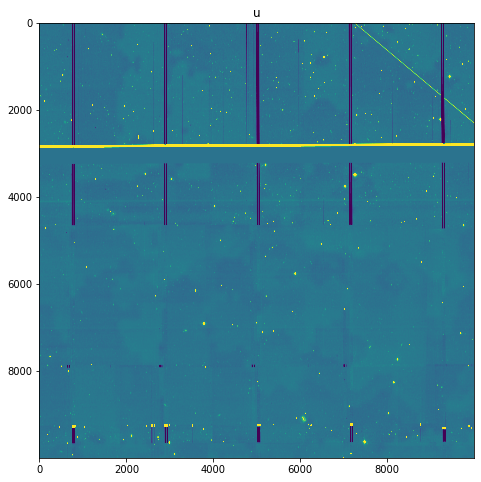

In [137]:
channels = ["u"]#, "r"]
plot_tiles = [u_data]#, r_data]
fig, axes = plt.subplots(1,len(channels), figsize=(12,8))
for i in range(len(channels)):
    norm = ImageNormalize(plot_tiles[i], interval=ZScaleInterval())
    axes.imshow(plot_tiles[i], norm=norm)
    axes.set_title(channels[i])
#plt.savefig("../../Plots/{}_tiles.png".format(tile))

In [141]:
#r_wcs = WCS(r_head)
u_wcs = WCS(u_head)
#r_df = pd.read_csv(subdir + "CFIS r/{}_labels.csv".format(tile))
u_df = pd.read_csv(subdir + "CFIS u/{}_labels.csv".format(tile))

In [155]:
from astropy.coordinates import SkyCoord
x,y = utils.skycoord_to_pixel(SkyCoord(u_df["ra"], u_df["dec"], unit="deg"), u_wcs)
print((x,y))

(array([7816.6296067]), array([8907.02415045]))


In [156]:
#r_cutout = Cutout2D(r_data, (x, y), cutout_size, mode="partial", fill_value=0).data
u_cutout = Cutout2D(u_data, (x, y), cutout_size, mode="partial", fill_value=0).data

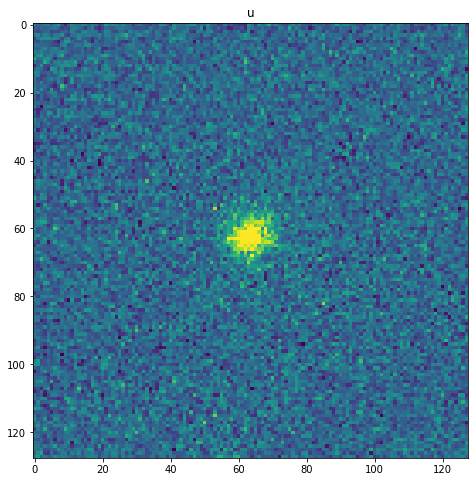

In [160]:
channels = ["u"]#, "r"]
plot_cutouts = [u_cutout]#, r_cutout]
fig, axes = plt.subplots(1,len(channels), figsize=(12,8))
for i in range(len(channels)):
    norm = ImageNormalize(plot_cutouts[i], interval=ZScaleInterval())
    axes.imshow(plot_cutouts[i], norm=norm)
    axes.set_title(channels[i])
#plt.savefig("Plots/{}_labelled_cutouts.png".format(tile))

# Plot cutouts from each resource

In [164]:
def get_cutouts(label_subdir, reconstruct=False):
    cutout_size = 128
    n_cutouts = 0
    for k in list(hf.get(label_subdir).keys()):
        f = list(hf.get(label_subdir + k).keys())[0]
        img_subgroup = hf.get(label_subdir + k + "/" + f + "/IMAGES")
        n_cutouts += len(img_subgroup)
       
    plot_cutouts = np.zeros((n_cutouts, cutout_size, cutout_size, 3), dtype=int)
    if "confirmed" in label_subdir:
        types = []
    n_tiles = len(list(hf.get(label_subdir).keys()))-1
    n_plots = 0
    tile_ids = list(hf.get(label_subdir).keys())
    tile_ids.pop(tile_ids.index(".ipynb_")) #remove 'ipynb' subdir
    for n in range(n_tiles):
        tile_id = tile_ids[n]
        f = list(hf.get(label_subdir + tile_id).keys())[0]
        df = pd.read_csv(label_dir + label_subdir + f + "/" + tile_id + "_labels.csv")
        img_subgroup = hf.get(label_subdir + tile_id + "/" + f + "/IMAGES")
        n_labels = len(img_subgroup)
        for i in range(n_labels):
            if "confirmed" in label_subdir:
                types.append(df["type"][i])
            cutout = np.zeros((cutout_size, cutout_size, 5))
            dataset_name = tile_id + str(i)
            filts = [f + "/" for f in list(hf.get(label_subdir + tile_id).keys())]
            filt_indices = [filter_dict.get(f) for f in filts]
            for (j, ind) in enumerate(filt_indices):
                cutout[:,:,ind] = hf.get(label_subdir + tile_id + "/" + filts[j] + "IMAGES/" + dataset_name)
            if reconstruct:
                cutout = autoencoder.predict(np.expand_dims(cutout, axis=0))[0]
            if len(filt_indices) == 1:
                if 2 in filt_indices: # red
                    cutout_r = cutout[:,:,2]
                    cutout_g = np.zeros((cutout_size, cutout_size))
                    cutout_b = np.zeros((cutout_size, cutout_size))
                elif 1 in filt_indices: # green
                    cutout_r = np.zeros((cutout_size, cutout_size))
                    cutout_g = cutout[:,:,1]
                    cutout_b = np.zeros((cutout_size, cutout_size))
                else:
                    cutout_r = np.zeros((cutout_size, cutout_size))
                    cutout_g = np.zeros((cutout_size, cutout_size))
                    cutout_b = cutout[:,:,filt_indices[0]]
                cutout_rgb = make_lupton_rgb(cutout_r, cutout_g, cutout_b, Q=10, stretch=3)
            elif len(filt_indices) == 2:
                if 2 in filt_indices: # red
                    cutout_r = cutout[:,:,2]
                else:
                    cutout_r = cutout[:,:,filt_indices[0]]
                if 1 in filt_indices: # green
                    cutout_g = cutout[:,:,1]
                else:
                    cutout_g = cutout[:,:,filt_indices[1]]
                cutout_b = np.zeros((cutout_size, cutout_size))
                cutout_rgb = make_lupton_rgb(cutout_r, cutout_g, cutout_b, Q=10, stretch=3)
            else:
                if 2 in filt_indices:
                    cutout_r = cutout[:,:,2]
                else:
                    cutout_r = cutout[:,:,filt_indices[0]]
                if 1 in filt_indices:
                    cutout_g = cutout[:,:,1]
                else:
                    cutout_g = cutout[:,:,filt_indices[1]]
                if 3 in filt_indices: # i band
                    cutout_b = cutout[:,:,3]
                else:
                    cutout_b = cutout[:,:,filt_indices[-1]]
                cutout_rgb = make_lupton_rgb(cutout_r, cutout_g, cutout_b, Q=10, stretch=3)
            plot_cutouts[n_plots,:,:,:] = cutout_rgb
            n_plots += 1
    if "confirmed" in label_subdir:
        return (plot_cutouts, types)
    else:
        return (plot_cutouts, _)

In [165]:
confirmed_cutouts, confirmed_types = get_cutouts(label_subdirs[2])

In [90]:
def custom_loss_all(y_true, y_pred):
    return keras.losses.MSE(y_true*np.sqrt(weights_all), y_pred*np.sqrt(weights_all))

In [91]:
autoencoder = keras.models.load_model("Models/autoencoder_128p",
                                 custom_objects={'custom_loss_all': custom_loss_all})

OSError: SavedModel file does not exist at: Models/autoencoder_128p/{saved_model.pbtxt|saved_model.pb}

In [ ]:
confirmed_reconstructed, _ = get_cutouts(label_subdirs[0], reconstruct=True)

In [ ]:
Counter(confirmed_types)

In [176]:
def plot_cutouts(cutouts, figname, ncols=6, types=None):
    n_cutouts = len(cutouts)
    nrows = int(np.ceil(n_cutouts/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.1*ncols,3.4*nrows))
    n_plots = 0
    for n1 in range(nrows):
        for n2 in range(ncols):
            cutout_rgb = cutouts[n_plots]
            norm = ImageNormalize(cutout_rgb, interval=ZScaleInterval())
            axes[n1][n2].imshow(cutout_rgb)#, norm=norm)
            if types is not None:
                axes[n1][n2].set_title(types[n_plots])
            n_plots += 1     
            if n_plots == n_cutouts:
                break
        if n_plots == n_cutouts:
                break

    # delete empty axes
    for i in range(n_cutouts, nrows*ncols):
        fig.delaxes(axes.flatten()[i])
    #plt.savefig(f"Plots/{figname}") 

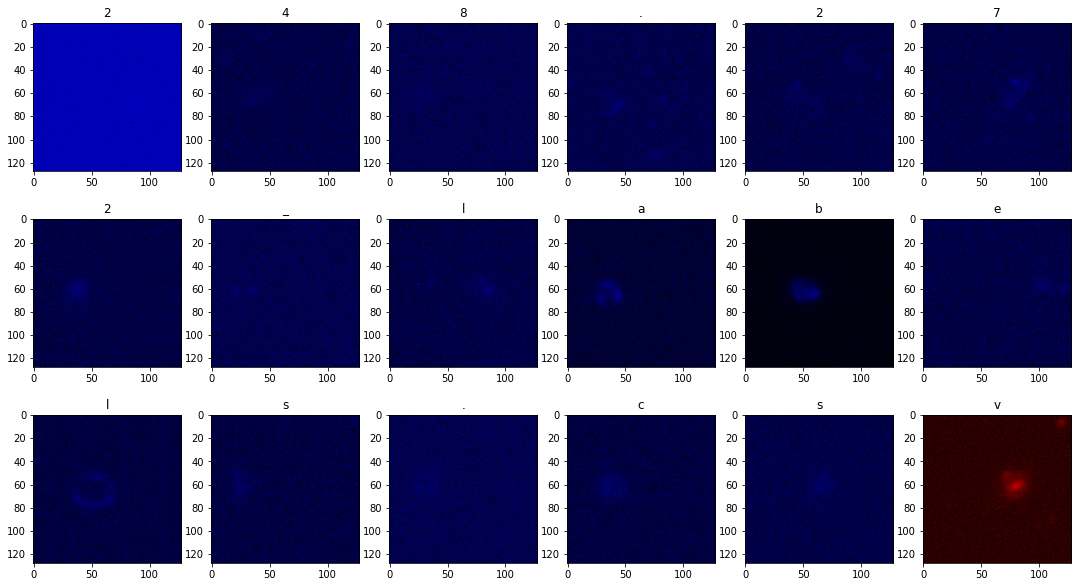

In [178]:
plot_cutouts(confirmed_cutouts[:18], "confirmed_cutouts_rgb_alt.png", types=confirmed_types)

In [ ]:
plot_cutouts(confirmed_reconstructed, "confirmed_reconstructed_rgb.png", types=confirmed_types)

In [ ]:
plot_indices = [14, 18, 23, 37, 80, 134, 137, 154, 184, 236]
confirmed_cutouts_report = [confirmed_cutouts[i] for i in plot_indices]
confirmed_types_report = [confirmed_types[i] for i in plot_indices]
plot_cutouts(confirmed_cutouts_report, "confirmed_cutouts_rgb_report.png", ncols=5, types=confirmed_types_report)

In [ ]:
candidate_cutouts, _ = get_cutouts(label_subdirs[1])

In [ ]:
plot_cutouts(candidate_cutouts, "candidate_cutouts_rgb.png")

In [ ]:
plot_indices = [20, 43, 63, 64, 88, 109, 211, 215, 368, 383]
candidate_cutouts_report = [candidate_cutouts[i] for i in plot_indices]
plot_cutouts(candidate_cutouts_report, "candidate_cutouts_rgb_report.png", ncols=5)

In [ ]:
canameras_cutouts, _ = get_cutouts(label_subdirs[2])

In [ ]:
plot_cutouts(canameras_cutouts, "canameras_cutouts_rgb.png")

In [ ]:
for label_subdir in label_subdirs[3:]:
    figname = label_subdir[:-1] + ".png"
    huang_cutouts, _ = get_cutouts(label_subdir)
    plot_cutouts(huang_cutouts, figname)

In [ ]:
def count_cutouts(label_subdir):
    n_cutouts = 0
    for k in list(hf.get(label_subdir).keys()):
        f = list(hf.get(label_subdir + k).keys())[0]
        img_subgroup = hf.get(label_subdir + k + "/" + f + "/IMAGES")
        n_cutouts += len(img_subgroup)
    print(label_subdir + ":" + str(n_cutouts))

In [ ]:
for label_subdir in label_subdirs[:]:
    count_cutouts(label_subdir)

In [ ]:
hf.close()
#src = os.path.expandvars("$SLURM_TMPDIR") + "/labelled_cutouts_alt.h5"
#dest = os.path.expandvars("$SCRATCH") + "/"
#shutil.copy2(src, dest)